<h2> 0.3 - Dataset path </h2>

<h1> 0 - Notebook preparation </h1>

<h2> 0.1 - packages installation </h2>

In [2]:
!pip install kagglehub
!pip install scipy
!pip install seaborn
!pip install statsmodels
!pip install ipympl
!pip install scikit-learn-extra

<h2> 0.2 - Imports </h2>

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency, pointbiserialr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn_extra.cluster import KMedoids


In [4]:

if 'vscode' in sys.modules:
    DATASET_PATH = './heart.csv'
elif 'google.colab' in sys.modules:
    dataset_folder = kagglehub.dataset_download('fedesoriano/heart-failure-prediction')
    DATASET_PATH = os.path.join(dataset_folder, 'heart.csv')
else:
    raise Exception('Unknown environment')

<h2> 0.4 - Global settings </h2>

<h2> 0.5 - Functions </h2>

In [5]:
def display_clusters_for_2_components(principalComponents, y_kmeans, kmeans, title):
    plt.scatter(principalComponents[y_kmeans == 0, 0], principalComponents[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
    plt.scatter(principalComponents[y_kmeans == 1, 0], principalComponents[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


def display_clusters_for_3_components(principalComponents, y_kmeans, kmeans, title):
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(principalComponents[y_kmeans == 0, 0], principalComponents[y_kmeans == 0, 1], principalComponents[y_kmeans == 0, 2], s=100, c='red', label='Cluster 1')
    ax.scatter(principalComponents[y_kmeans == 1, 0], principalComponents[y_kmeans == 1, 1], principalComponents[y_kmeans == 1, 2], s=100, c='blue', label='Cluster 2')
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300)
    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()
    plt.show()

def display_clusters(principalComponents, clusters, algorithm_obj, title):
    if principalComponents.shape[1] == 2:
        display_clusters_for_2_components(principalComponents, clusters, algorithm_obj, title)
    elif principalComponents.shape[1] == 3:
        display_clusters_for_3_components(principalComponents, clusters, algorithm_obj, title)
    else:
        raise Exception('Unsupported number of components')

In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)
RANDOM_STATE = 42

<h1> 1 - Data Exploration and visualization </h1>

<h2> 1.1 - Overview (first part) </h2>

In [7]:
df = pd.read_csv(DATASET_PATH)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.20,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.40,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.20,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.00,Flat,1


<h2> 1.2 - Overview (second part)</h2>

In [8]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


<h2> 1.3 - Frequency plot & histogram </h2>

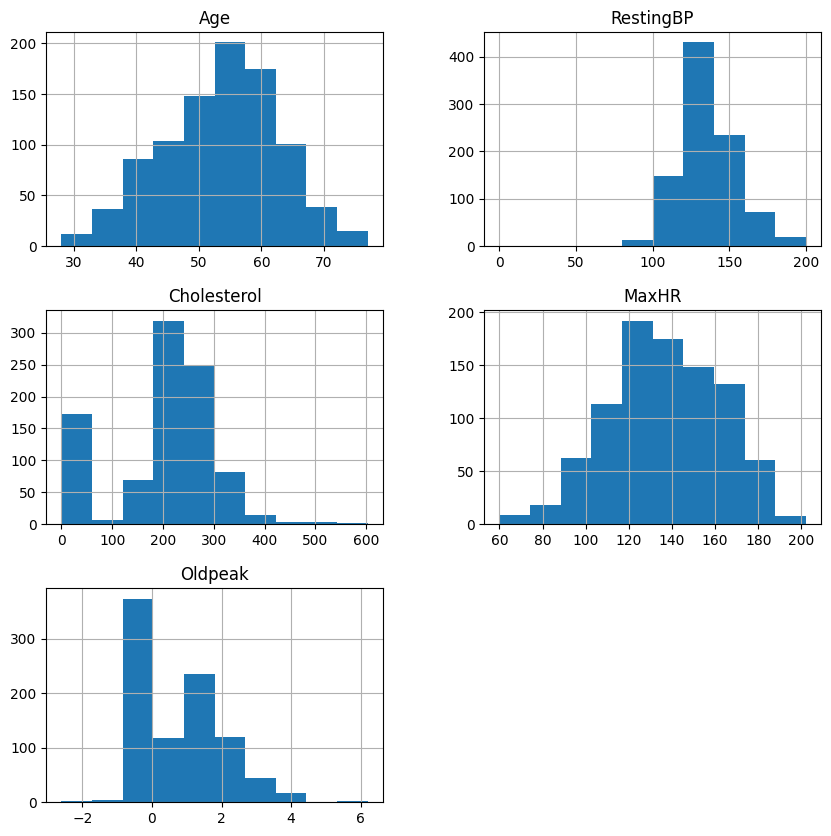

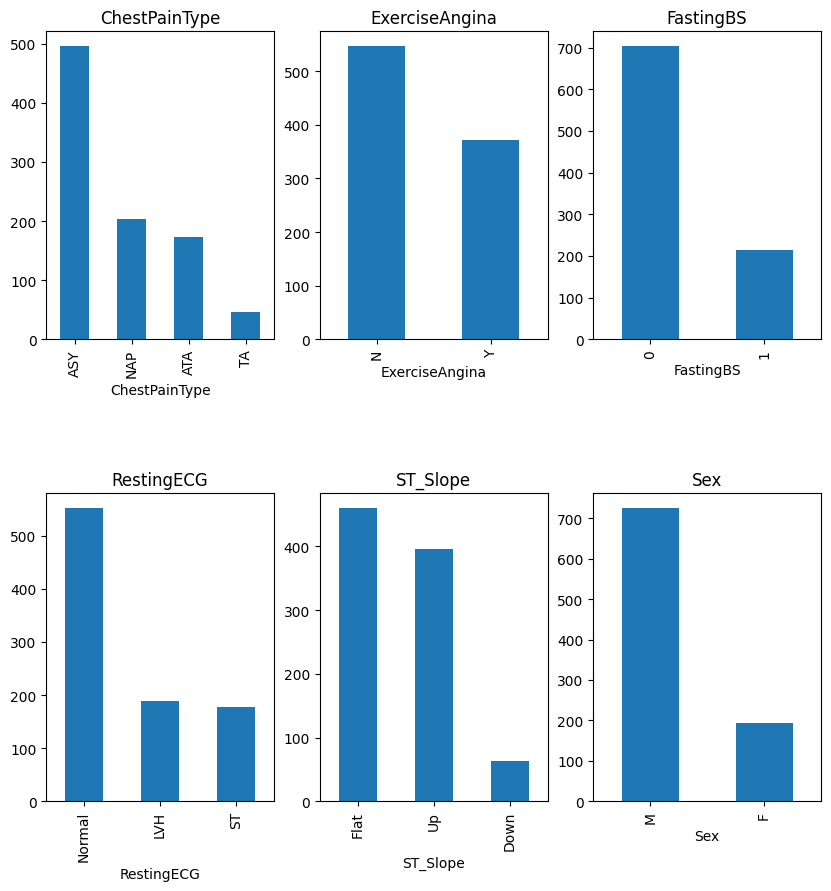

In [9]:
#-------- plot continuous features
CONTINUOUS_FEATURES = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[CONTINUOUS_FEATURES].hist(figsize=(10, 10))

#-------- plot categorical features
CATEGORICAL_FEATURES = df.columns.difference(CONTINUOUS_FEATURES).difference(['HeartDisease'])
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.5)
for i, feature in enumerate(CATEGORICAL_FEATURES):
    df[feature].value_counts().plot(kind='bar', ax=axes[i], title=feature, width=0.5)


<h2> 1.4 - Probability density function (groupd graphs)</h2>

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>]], dtype=object)

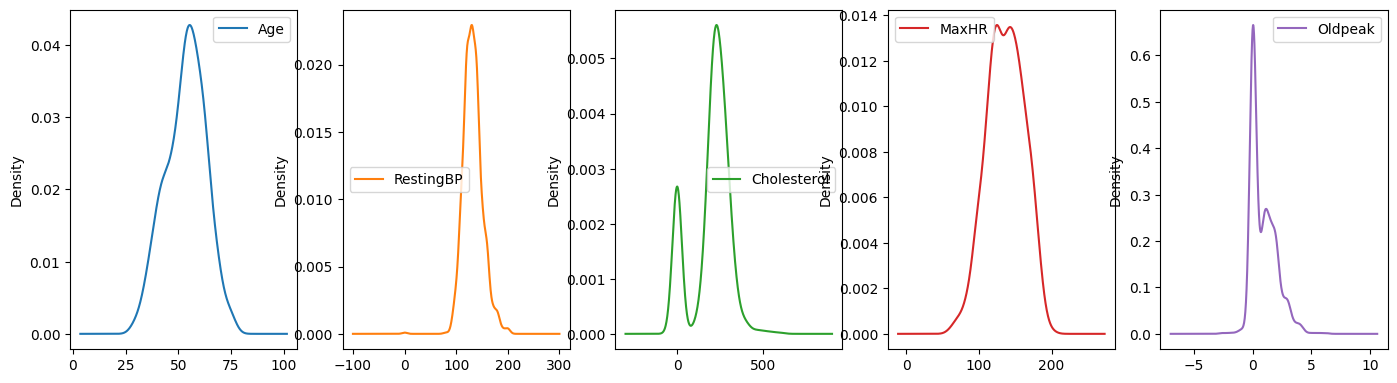

In [10]:
# plot the probability density function for each numerical feature
df[CONTINUOUS_FEATURES].plot(kind='density', subplots=True, layout=(3,5), sharex=False,figsize=(17,15))

<h2> 1.5 - Probability density function (individual graphs)</h2>

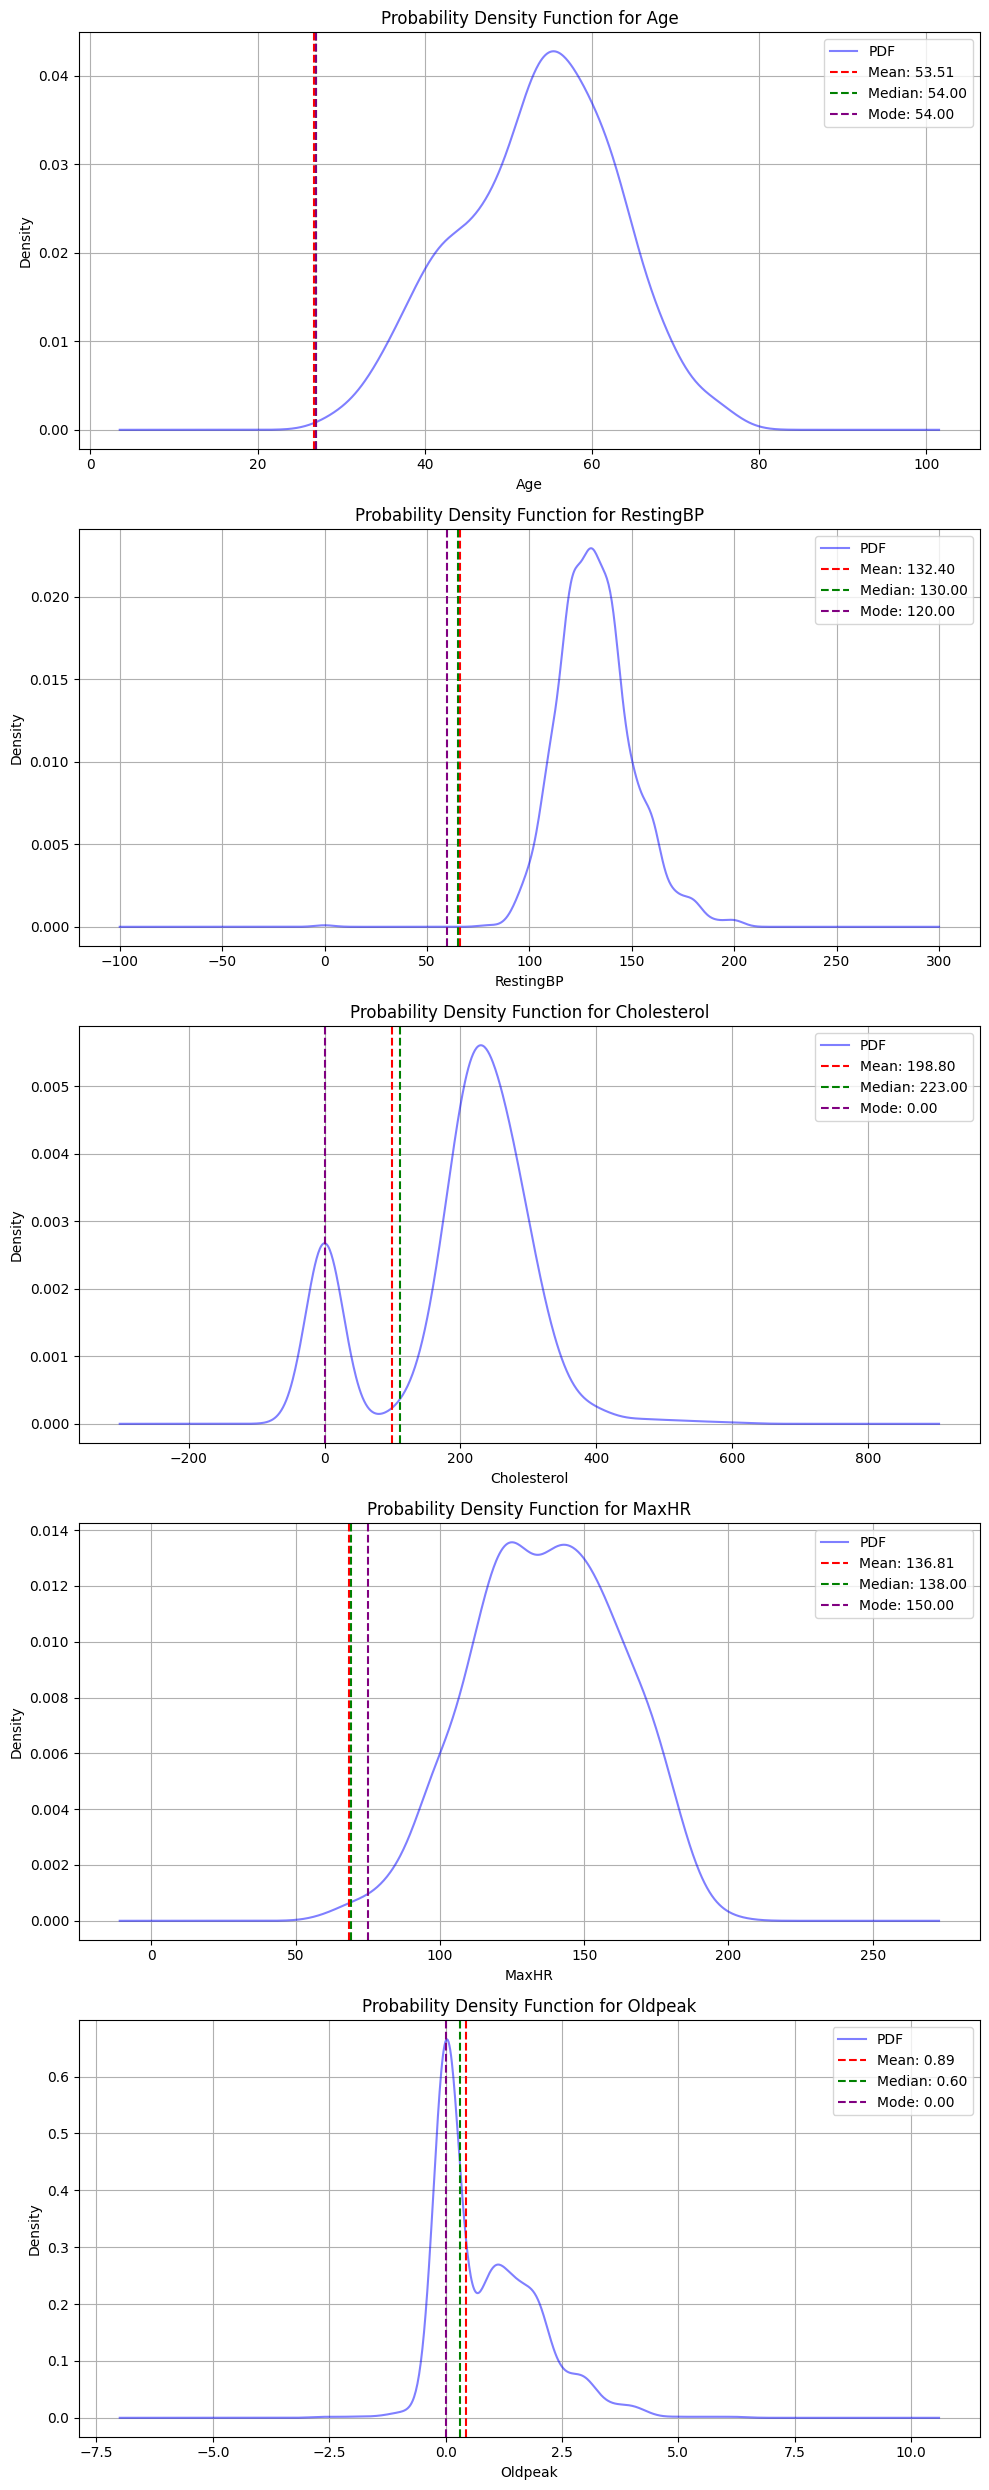

In [11]:
# (this cell does the same thing as the previous cell, but additionally display the mean, median and mode for each column)

num_features = len(CONTINUOUS_FEATURES)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Loop through each feature to create a PDF plot
for i, column in enumerate(CONTINUOUS_FEATURES):
    # Plotting the density
    df[column].plot(kind='density', ax=axes[i], color='blue', alpha=0.5, label='PDF')

    # Calculate mean, median, and mode
    mean = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()[0]

    # Marking mean, median, and mode with horizontal lines
    axes[i].axvline(x=mean / 2, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Adjusted y-value for visibility
    axes[i].axvline(x=median / 2, color='green', linestyle='--', label=f'Median: {median:.2f}')  # Adjusted y-value for visibility
    axes[i].axvline(x=mode / 2, color='purple', linestyle='--', label=f'Mode: {mode:.2f}')  # Adjusted y-value for visibility

    # Adding titles and labels
    axes[i].set_title(f'Probability Density Function for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

<h2> 1.6 - Skeweness</h2>

In [12]:
# plot the skewness for each column
df[CONTINUOUS_FEATURES].skew()

Age           -0.20
RestingBP      0.18
Cholesterol   -0.61
MaxHR         -0.14
Oldpeak        1.02
dtype: float64

<h2> 1.7 - Box plot</h3>

Age               Axes(0.125,0.747241;0.227941x0.132759)
RestingBP      Axes(0.398529,0.747241;0.227941x0.132759)
Cholesterol    Axes(0.672059,0.747241;0.227941x0.132759)
MaxHR             Axes(0.125,0.587931;0.227941x0.132759)
Oldpeak        Axes(0.398529,0.587931;0.227941x0.132759)
dtype: object

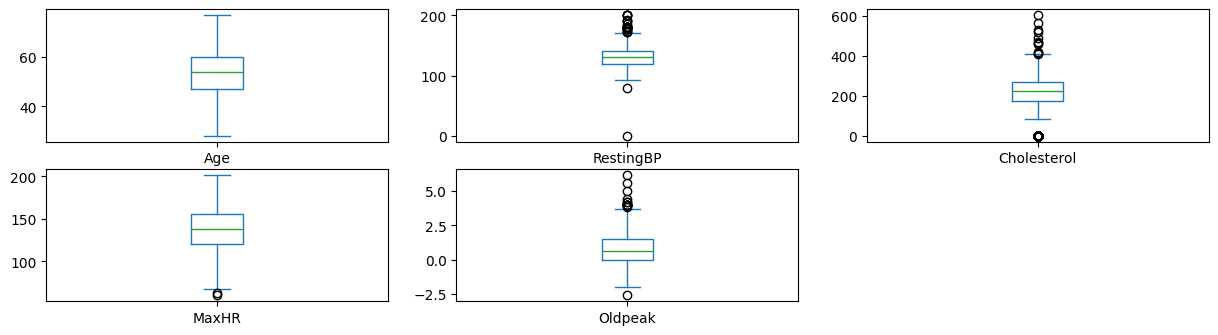

In [13]:
df[CONTINUOUS_FEATURES].plot(kind='box', subplots=True, sharex=False, sharey=False, layout=(5,3), figsize=(15,10))

<h1> 2 - Data cleaning and processing </h1>

<h2> 2.1 - Handling missing values </h2>

In [14]:
# Check for missing values in each column
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Given that the dataset contains no missing values for any of the features, there was no need to perform replacement for missing values, dropping any rows with missing values, or dropping any features.

<h2> 2.2 - Remove Outliers </h2>

In [15]:
def remove_outliers(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    return column[(column >= Q1 - 1.5 * IQR) & (column <= Q3 + 1.5 * IQR)]

for column in CONTINUOUS_FEATURES:
    initial_count = df[column].count()
    df[column] = remove_outliers(df[column])
    final_count = df[column].count()
    print(f'{column}: was {initial_count} values, became {final_count}')


Age: was 918 values, became 918
RestingBP: was 918 values, became 890
Cholesterol: was 918 values, became 735
MaxHR: was 918 values, became 916
Oldpeak: was 918 values, became 902


<h2> 2.3 - Drop rows with NaN values that resulted from outlier removal </h2>

In [16]:
df.dropna(subset=CONTINUOUS_FEATURES, inplace=True)
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,702.00,702.00,702.00,702.00,702.00,702.00,702.00
mean,52.72,131.56,239.71,0.16,140.55,0.83,0.46
std,9.54,15.42,50.68,0.37,24.36,0.96,0.50
min,28.00,92.00,85.00,0.00,71.00,-0.10,0.00
25%,46.00,120.00,206.00,0.00,122.00,0.00,0.00
50%,54.00,130.00,235.00,0.00,140.00,0.40,0.00
75%,59.00,140.00,272.00,0.00,160.00,1.50,1.00
max,77.00,170.00,404.00,1.00,202.00,3.60,1.00


<h2> 2.4 - Deal with duplicates </h2>

In [17]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicates: {num_duplicates}')

Number of duplicates: 0


<h2> 2.5 - Feature scaling </h2>

We opt for Standardization becauase: These features have different units (e.g., mmHg, mg/dL) and wide ranges. Standardization ensures they are on a comparable scale (mean 0, standard deviation 1) while preserving the shape of the distribution.

In [18]:
sc = StandardScaler()
df[CONTINUOUS_FEATURES] = sc.fit_transform(df[CONTINUOUS_FEATURES])
df[CONTINUOUS_FEATURES]

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,-1.34,0.55,0.97,1.29,-0.87
1,-0.39,1.85,-1.18,0.63,0.18
2,-1.65,-0.10,0.85,-1.75,-0.87
3,-0.50,0.42,-0.51,-1.34,0.70
4,0.13,1.20,-0.88,-0.76,-0.87
...,...,...,...,...,...
913,-0.81,-1.40,0.48,-0.35,0.38
914,1.60,0.81,-0.92,0.02,2.68
915,0.45,-0.10,-2.15,-1.05,0.38
916,0.45,-0.10,-0.07,1.37,-0.87


<h1> 3 - Feature extraction & selection </h1>

<h2> 3.1 - Correlation </h2>

<h2> 3.1.1 - Correlation between numerical features</h2>

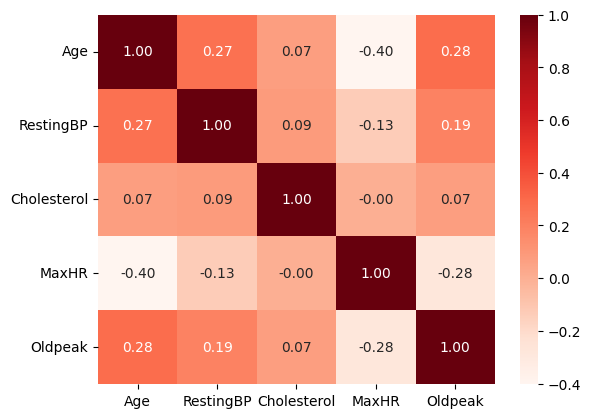

In [19]:
# numerical - numerical correlation
selected_df_corr = df.loc[:,CONTINUOUS_FEATURES]
correlation_matrix = selected_df_corr.corr()  # Calculate correlation matrix for numerical columns
sns.heatmap(correlation_matrix, cmap='Reds', annot=True, fmt='.2f')
plt.show()

The strongest correlation is between the features 'Age' and 'Oldpeak' (= 0.28), lets plot these 2 features to see the correlation better

<Axes: xlabel='Age', ylabel='Oldpeak'>

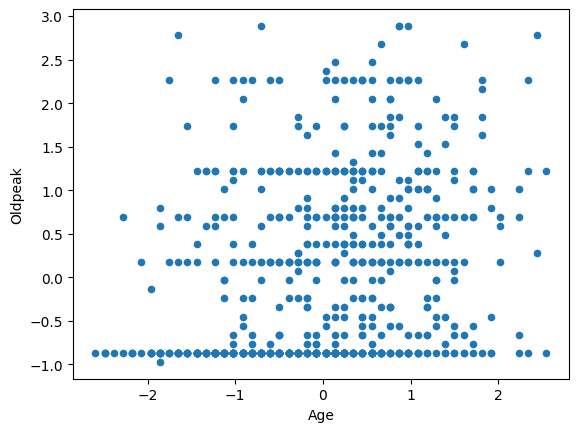

In [20]:
df.plot(kind='scatter', x='Age',y='Oldpeak')

From the plot, It is clear that there is no strong correlation between the features 'Age' and 'Oldpeak'.

Since the strongest correlation between any 2 numerical featurs = 0.28, which is cleary not strong from the graph, we decide not to exclude any of the features.

<h2> 3.1.2 - Correlation between categorical features</h2>

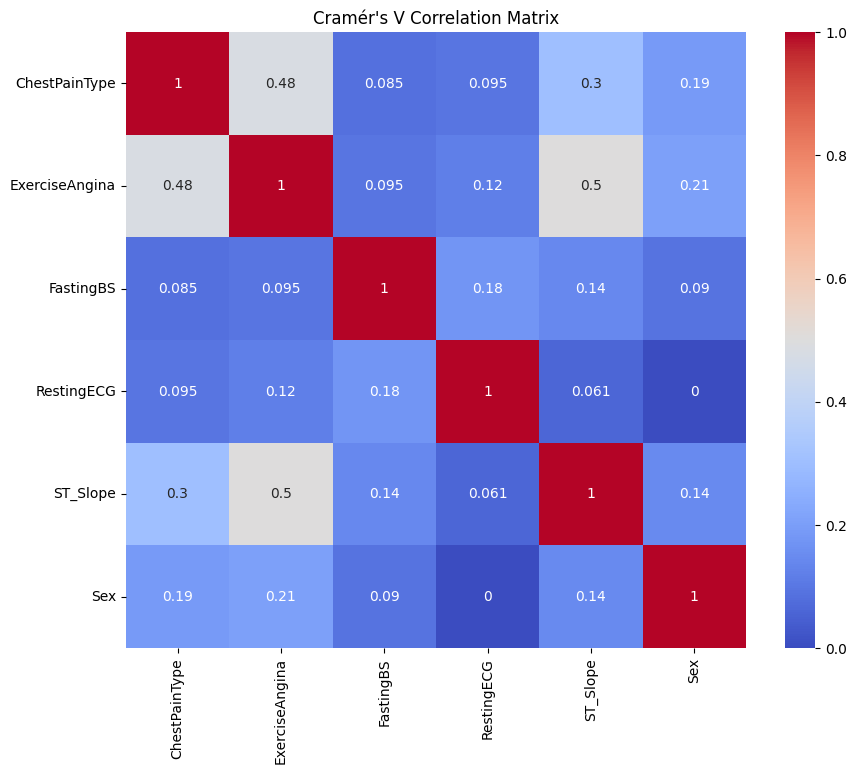

In [21]:
# Categorical - Categorical correlation
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_features = df.loc[:, CATEGORICAL_FEATURES]
corr_matrix = pd.DataFrame(np.zeros((len(categorical_features.columns), len(categorical_features.columns))), 
                           index=categorical_features.columns, columns=categorical_features.columns)

for col1 in categorical_features.columns:
    for col2 in categorical_features.columns:
        if col1 != col2:
            corr_matrix.loc[col1, col2] = cramers_v(categorical_features[col1], categorical_features[col2])
        else:
            corr_matrix.loc[col1, col2] = 1.0

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Cramér\'s V Correlation Matrix')
plt.show()

As we can see, the strongest correlation = 0.5 between (ST_Slope) & (ExerciseAngina) which is not strong enough to exclude any of them.

<h2> 3.1.3 - Correlation between numerical - categorical features</h2>

C:\Users\Dell\AppData\Local\Temp\ipykernel_352\258967322.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return anova_table['sum_sq'][0] / anova_table['sum_sq'].sum()
C:\Users\Dell\AppData\Local\Temp\ipykernel_352\258967322.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return anova_table['sum_sq'][0] / anova_table['sum_sq'].sum()
C:\Users\Dell\AppData\Local\Temp\ipykernel_352\258967322.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

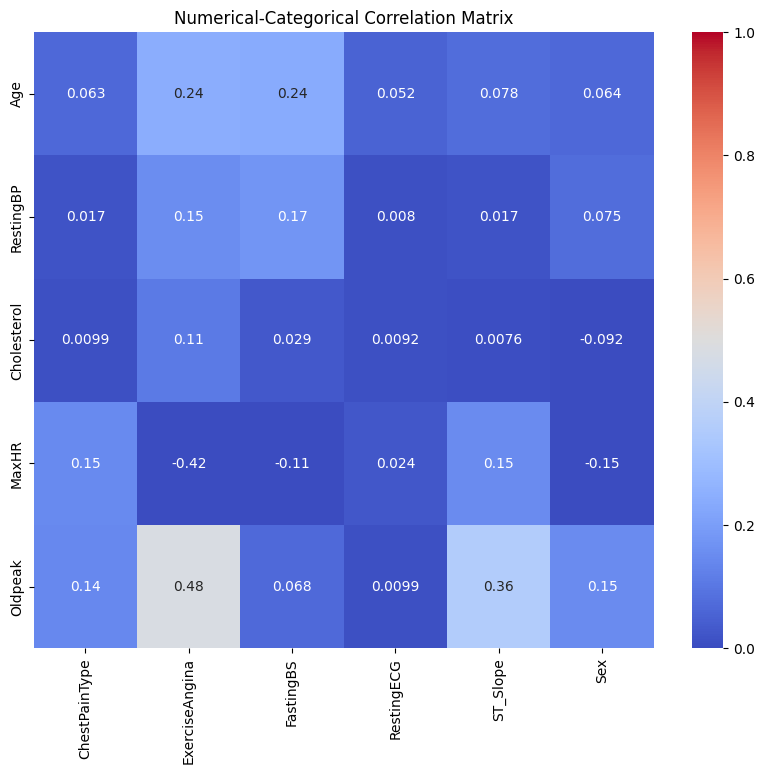

In [22]:

def eta_squared(anova_table):
    return anova_table['sum_sq'][0] / anova_table['sum_sq'].sum()

numerical_categorical_corr = pd.DataFrame(index=CONTINUOUS_FEATURES, columns=CATEGORICAL_FEATURES)

for cat_col in CATEGORICAL_FEATURES:
    if df[cat_col].nunique() == 2:  # Binary categorical variable
        # Convert binary categorical column to numerical values (0 and 1)
        df[cat_col] = df[cat_col].astype('category').cat.codes
        for num_col in CONTINUOUS_FEATURES:
            correlation, p_value = pointbiserialr(df[cat_col], df[num_col])
            numerical_categorical_corr.loc[num_col, cat_col] = correlation
    else:  # Categorical variable with more than two categories
        for num_col in CONTINUOUS_FEATURES:
            model = ols(f'{num_col} ~ C({cat_col})', data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            eta_sq = eta_squared(anova_table)
            numerical_categorical_corr.loc[num_col, cat_col] = eta_sq

# Display the numerical-categorical correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_categorical_corr.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Numerical-Categorical Correlation Matrix')
plt.show()

Again, the max correlation between numerical & categorical features = 0.48 between the (oldpeak) & (ExerciseAngina) which is not strong enough to exclude any of them.

<h2> 3.2 - Endocing Categorical Features </h2>

In [23]:
# convert categorical columns to numerical
numerical_data = df[CONTINUOUS_FEATURES]
encoded_data = pd.get_dummies(df[CATEGORICAL_FEATURES])

fully_numerical_df = pd.concat([numerical_data, encoded_data], axis=1)
fully_numerical_df


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,ExerciseAngina,FastingBS,Sex,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.34,0.55,0.97,1.29,-0.87,0,0,1,False,True,False,False,False,True,False,False,False,True
1,-0.39,1.85,-1.18,0.63,0.18,0,0,0,False,False,True,False,False,True,False,False,True,False
2,-1.65,-0.10,0.85,-1.75,-0.87,0,0,1,False,True,False,False,False,False,True,False,False,True
3,-0.50,0.42,-0.51,-1.34,0.70,1,0,0,True,False,False,False,False,True,False,False,True,False
4,0.13,1.20,-0.88,-0.76,-0.87,0,0,1,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.81,-1.40,0.48,-0.35,0.38,0,0,1,False,False,False,True,False,True,False,False,True,False
914,1.60,0.81,-0.92,0.02,2.68,0,1,1,True,False,False,False,False,True,False,False,True,False
915,0.45,-0.10,-2.15,-1.05,0.38,1,0,1,True,False,False,False,False,True,False,False,True,False
916,0.45,-0.10,-0.07,1.37,-0.87,0,0,0,False,True,False,False,True,False,False,False,True,False


<h2> 3.3 PCA analysis </h2>

In [24]:

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(fully_numerical_df)

# Evaluate PCA
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Reserved variance in each component: {[f"{var:.2f}" for var in explained_variance_ratio]}')
print(f"Total variance Reserved across all components: {np.sum(explained_variance_ratio):.2f}")

Reserved variance in each component: ['0.29', '0.14', '0.13']
Total variance Reserved across all components: 0.56


<h1> 4 - Clustering </h1>

To help us deterime a good clustering technique, Lets plot PCA outputs

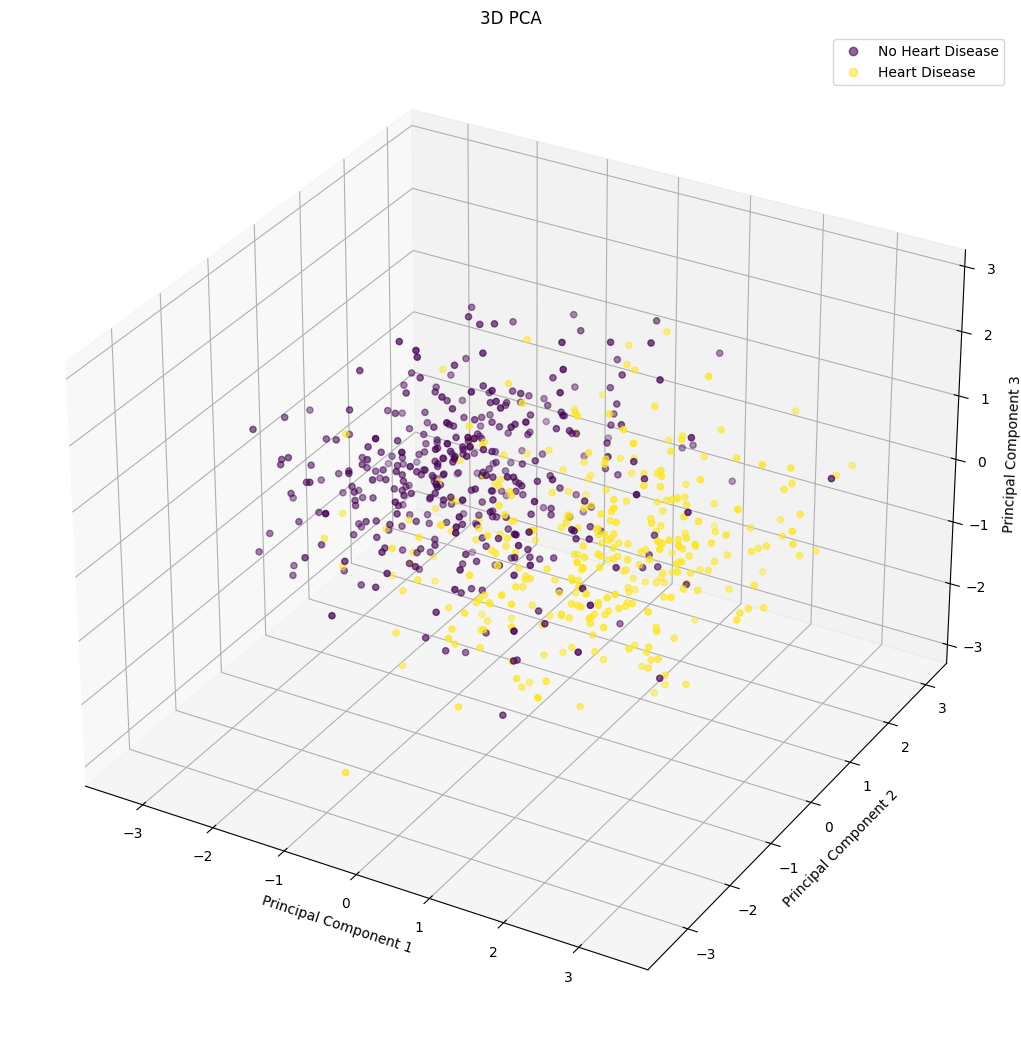

In [25]:
def plot_2d_pca(principalComponents):
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=df['HeartDisease'], cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D PCA')
    # Create custom legend
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend_labels = ['No Heart Disease', 'Heart Disease']
    plt.legend(handles, legend_labels)
    plt.show()


def plot_3d_pca(principalComponents):
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:, 2], c=df['HeartDisease'], cmap='viridis')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA')
    # Create custom legend
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend_labels = ['No Heart Disease', 'Heart Disease']
    ax.legend(handles, legend_labels)
    plt.show()
    
if principalComponents.shape[1] == 2:
    plot_2d_pca(principalComponents)
elif principalComponents.shape[1] == 3:
    plot_3d_pca(principalComponents)


It is clear from the distribution of the points that a good clustering type is (partitional clustering). We will try (K-means) & (K-Mediods) and compare between them. To determine a good number of clusters, we will use both the (Elbow method) & (Silhouette Coefficient)

<h2> 4.1 - K-means </h2>

<h3> 4.1.1 Choosing the right number of clusters using (Elbow Method) </h3>

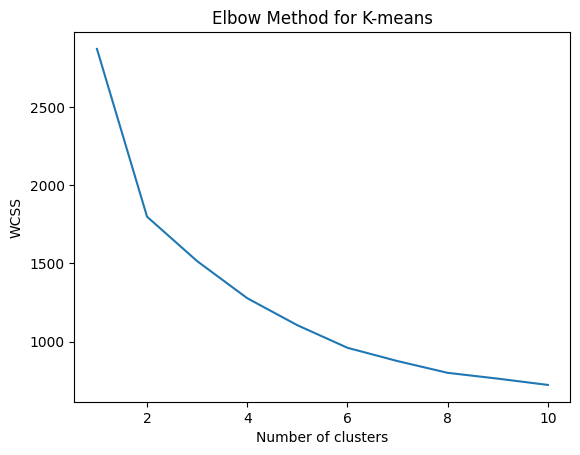

In [26]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=RANDOM_STATE)
    kmeans.fit(principalComponents)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for K-means')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



As we can see from the graph of the elbow method with k-means, the optimal number of clusters is 2.

<h3> 4.1.2 Choosing the right number of clusters using (Silhouette Coefficient) </h3>

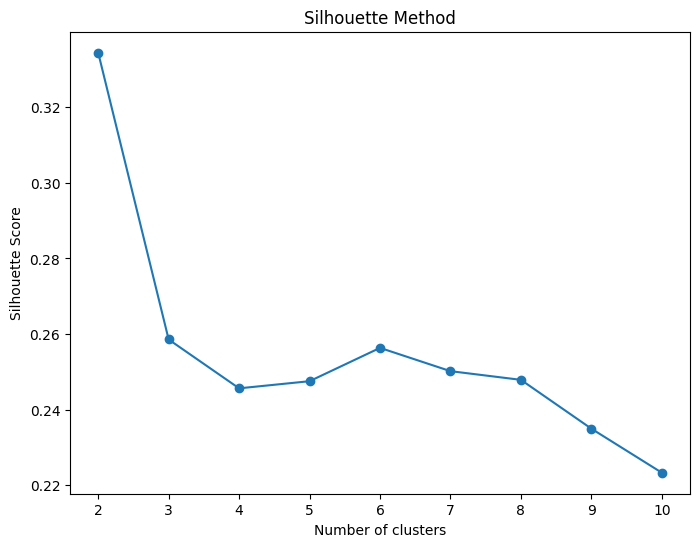

In [27]:
kmeans_silhouette_scores = []

range_n_clusters = list(range(2, 11))

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=RANDOM_STATE)
    kmeans.fit(principalComponents)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(principalComponents, cluster_labels)
    kmeans_silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, kmeans_silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

As we can see from the graph of silhouette score with k-means, the optimal number of clusters , is also 2. So for k-means, both elbow method & silhouette score agreed that the best k is 2

<h3> 4.1.3 - Perform & visualize k-means </h3>

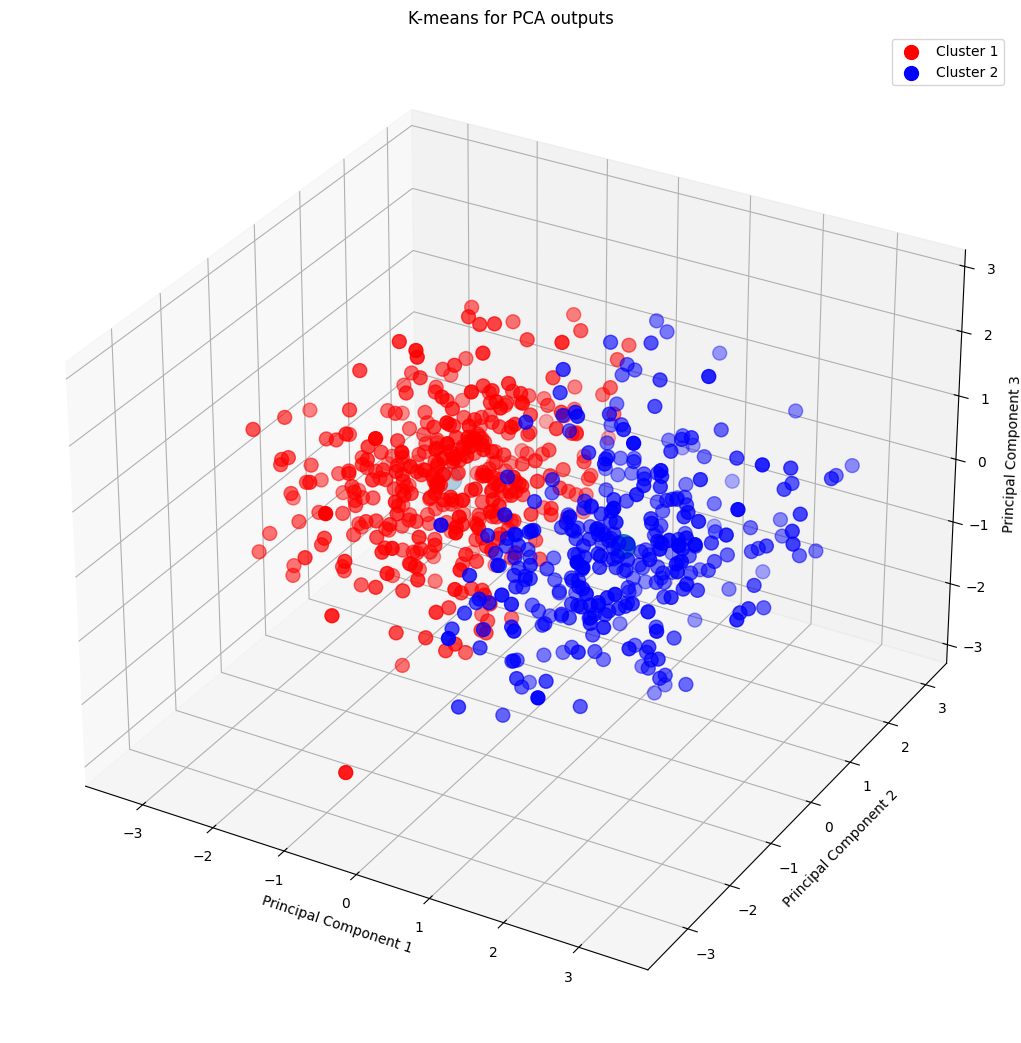

In [28]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=RANDOM_STATE)
y_kmeans = kmeans.fit_predict(principalComponents)
display_clusters(principalComponents, y_kmeans, kmeans, 'K-means for PCA outputs')

It is clear that the plot is similar to the PCA plot is section (), which is a good sign that the clustering is good.

<h2> 4.2 - K-medoids </h2>

<h3> 4.2.1 Choosing the right number of clusters using (Elbow Method) </h3>

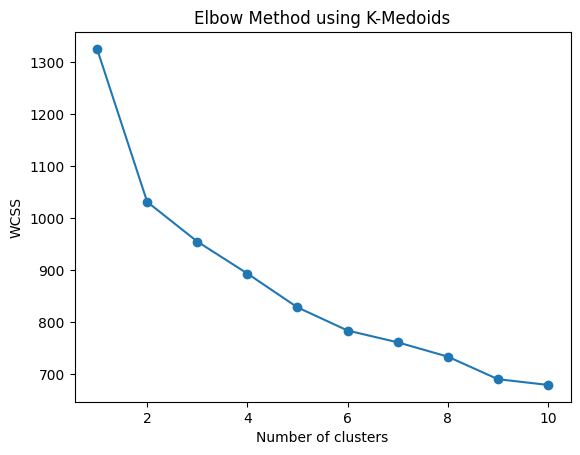

In [29]:
wcss = []
for i in range(1, 11):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', random_state=RANDOM_STATE)
    kmedoids.fit(principalComponents)
    wcss.append(kmedoids.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method using K-Medoids')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

As we can see from the graph of the elbow method with k-medoids, the optimal number of clusters is 2 (just like the elbow-method with k-means)

<h3> 4.2.2 Choosing the right number of clusters using (Silhouette Coefficient) </h3>

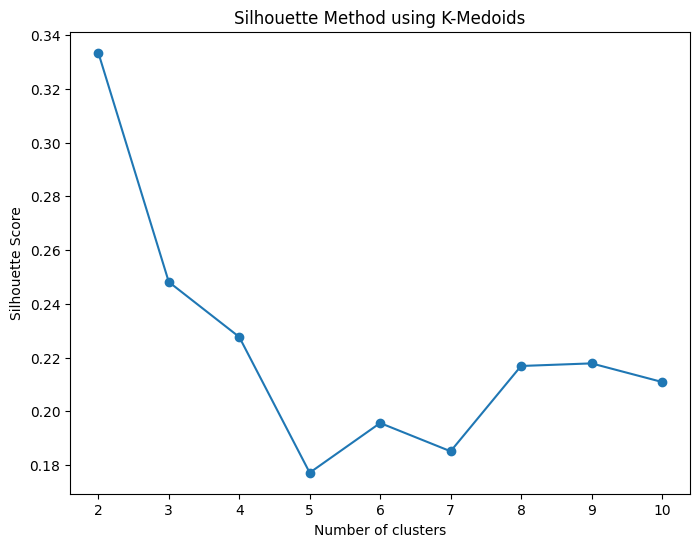

In [30]:
kmedoids_silhouette_scores = []

range_n_clusters = list(range(2, 11))

for n_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=RANDOM_STATE)
    kmedoids.fit(principalComponents)
    cluster_labels = kmedoids.labels_
    silhouette_avg = silhouette_score(principalComponents, cluster_labels)
    kmedoids_silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, kmedoids_silhouette_scores, marker='o')
plt.title('Silhouette Method using K-Medoids')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

As we can see from the graph of silhouette score with k-medoids, the optimal number of clusters is also 2. So both elbow method & silhouette score agreed that the best k is 2

<h3> 4.2.3 - Perform & visualize k-medoids </h3>

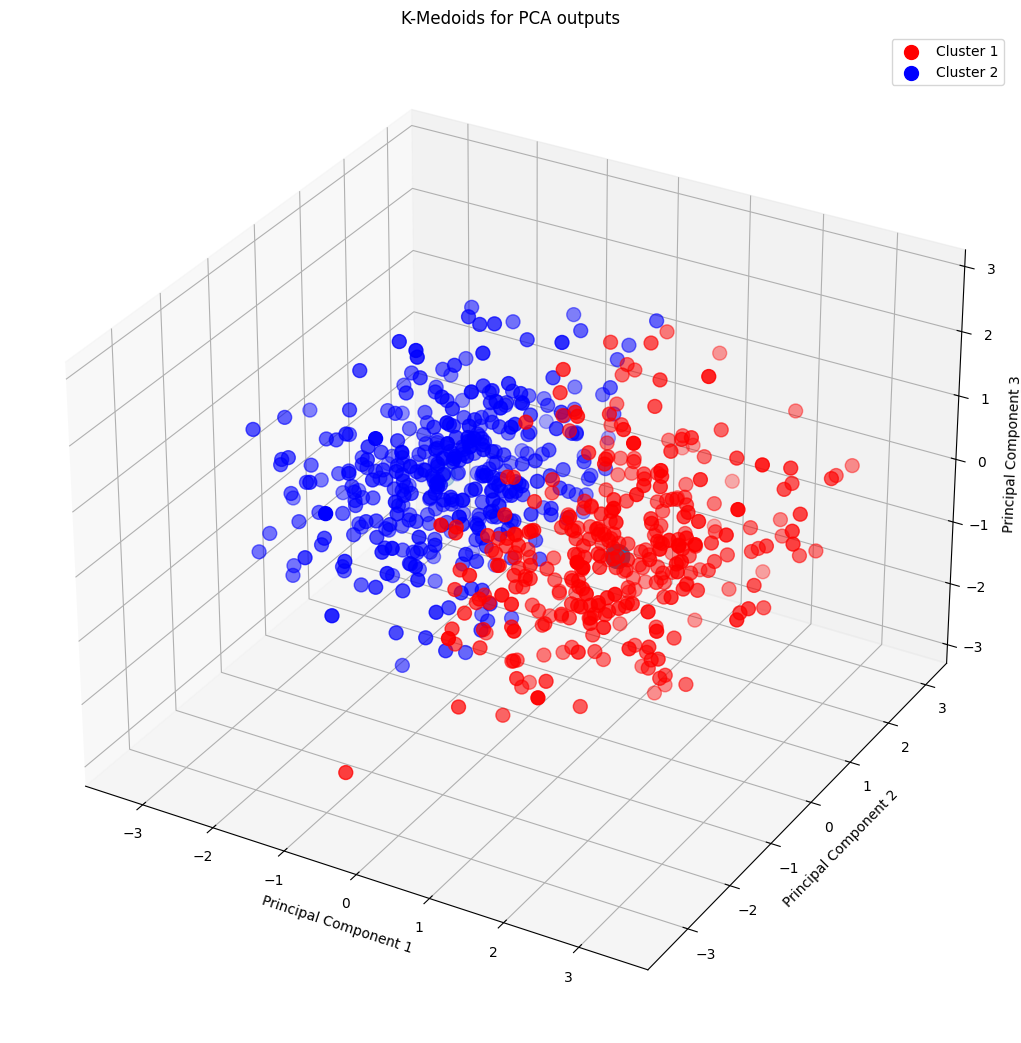

In [31]:
kmedoids = KMedoids(n_clusters=2, init='k-medoids++', random_state=RANDOM_STATE)
y_kmedoids = kmedoids.fit_predict(principalComponents)
display_clusters(principalComponents, y_kmedoids, kmedoids, 'K-Medoids for PCA outputs')

We can see that both elbow method & silhouette score for both k-means & k-medoids agreed that the best number of clusters is 2. which is logical since the target feature (Heart Disease) has 2 classes as well.

<h2> 4.3 - Hierarchical clustering</h2>

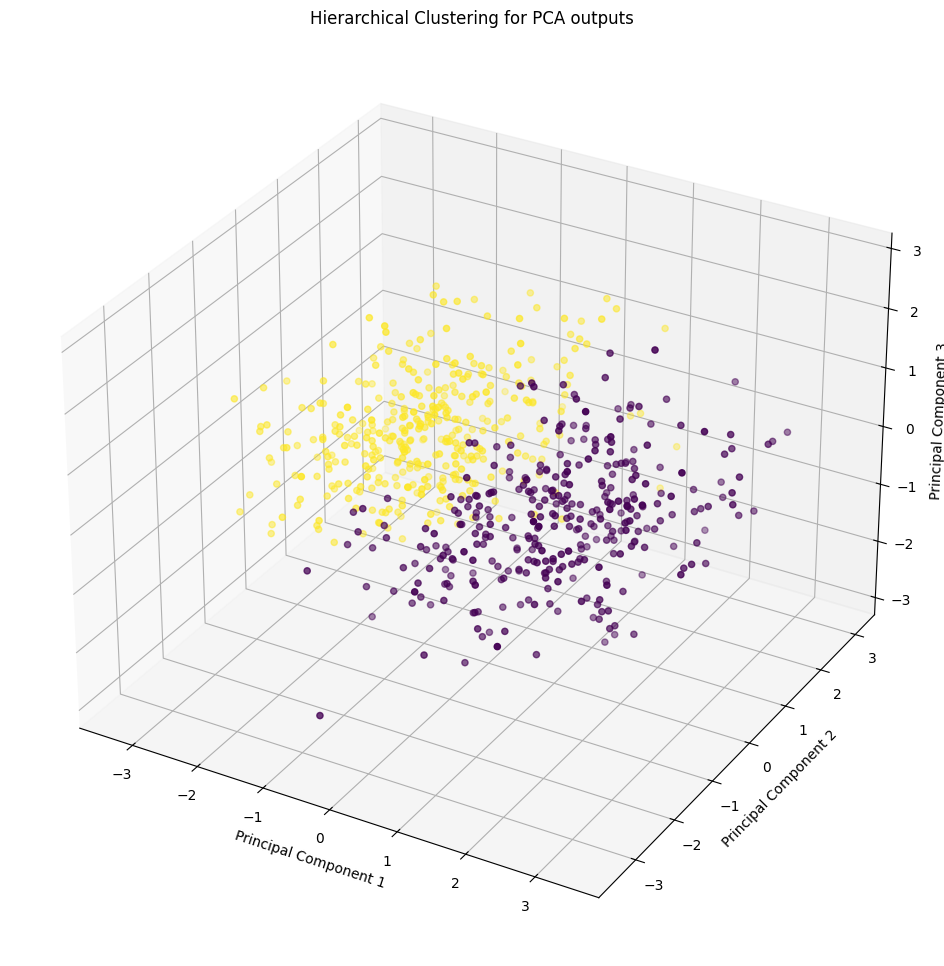

In [32]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=2)
y_hierarchical = hierarchical_clustering.fit_predict(principalComponents)

# Plot the clusters
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:, 2], c=y_hierarchical, cmap='viridis')
ax.set_title('Hierarchical Clustering for PCA outputs')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

<h2> 4.4 - Compare clustering techniques </h2>

<h3> Compare different clustering techniques with respect to ground truth (heartdisease) using Adjust Rand Index (ARI) & Normalized Mutual Information (NMI) </h3>

In [ ]:


target = df['HeartDisease']

# Calculate ARI and NMI for each clustering result compared to the ground truth
ari_hierarchical = adjusted_rand_score(target, y_hierarchical)
nmi_hierarchical = normalized_mutual_info_score(target, y_hierarchical)
# silhouette_hierarchical = silhouette_score(principalComponents, y_hierarchical)

ari_kmedoids = adjusted_rand_score(target, y_kmedoids)
nmi_kmedoids = normalized_mutual_info_score(target, y_kmedoids)
# silhouette_kmedoids = silhouette_score(principalComponents, y_kmedoids)

ari_kmeans = adjusted_rand_score(target, y_kmeans)
nmi_kmeans = normalized_mutual_info_score(target, y_kmeans)
# silhouette_kmeans = silhouette_score(principalComponents, y_kmeans)

# Print the results
print(f"KMeans - ARI: {ari_kmeans:.2f}, NMI: {nmi_kmeans:.2f}")
print(f"KMedoids - ARI: {ari_kmedoids:.2f}, NMI: {nmi_kmedoids:.2f}")
print(f"Hierarchical Clustering - ARI: {ari_hierarchical:.2f}, NMI: {nmi_hierarchical:.2f}")


KMeans - ARI: 0.36, NMI: 0.28
KMedoids - ARI: 0.36, NMI: 0.28
Hierarchical Clustering - ARI: 0.39, NMI: 0.30


We can see that Hierarchical clustering has the highest ARI & NMI scores, which means it better than kmeans & kmedoids for this dataset.

<h1> 5 - Classification </h1>

## Model selection

## Model training

## Model evaluation